# Classification and Analysis of Bank Marketing Dataset Using Various Machine Learning Models

source: https://www.kaggle.com/henriqueyamahata/bank-marketing

## 1. Libraries and Dependencies

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
%matplotlib inline

## 2. Data Loading

In [61]:
df = pd.read_csv("data/bank-additional-full.csv", delimiter=";")

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
df.shape

(41188, 21)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

We have a big dataset with 41,188 rows and 20 columns, including a target column.

## 3. Data Preprocessing

There are some columns which have unknown as values in the dataset. We can keep and treat them as category or we can drop them. Let's identify and fix them.

In [62]:
def get_columns_with_unknown(data):
    columns = data.select_dtypes(include=object).columns
    return [column for column in columns if data[column].str.contains("unknown").any()]

get_columns_with_unknown(df)

['job', 'marital', 'education', 'default', 'housing', 'loan']

These columns contains unknown as a value. Let's drop the rows which has unknown in it.

Let's find how many rows will it affect.

In [63]:
df[df[df == "unknown"].any(axis=1)].shape

(10700, 21)

There are 10,700 rows with 'unknown' as a value. While we could choose to keep and preprocess them, due to the size of our dataset, we will opt to drop them for now.

In [64]:
df = df.applymap(lambda x: np.nan if x == 'unknown' else x)
df.dropna(inplace=True)

#### Let's check for duplicate values

In [65]:
df.duplicated().sum()

10

There are 10 duplicate values. We'll drop them for now.

In [66]:
df.drop_duplicates(inplace=True)

#### Let's assign 0 and 1 to the target column

In [67]:
df["y"] = df["y"].apply(lambda x: 0 if x == "no" else 1)

#### Let's seperate X and y variables for further evaluation.

In [68]:
X = df.drop(columns=["y"])
y = df["y"]

#### Let's use one-hot encoding for the categorical variables.

In [69]:
cat_features = X.select_dtypes(include=object).columns
num_features = X.select_dtypes(include=[int, float]).columns

In [70]:
X = pd.get_dummies(X, columns=cat_features)

In [71]:
X

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
6,59,139,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,1,0,0,0,0,0,1,0


After using one-hot encoding we have 57 features. 

## 4. Model Building

#### Let's split the data

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=True, random_state=9)

#### Let's use standard scaler to scale the data 

In [86]:
scaler = StandardScaler()

In [87]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Let's try out different models on this dataset.

### A) Logistic Regression

In [106]:
# Param grid for Logistic Regression
param_grid_log_reg = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

In [107]:
log_reg = LogisticRegression(max_iter=1000)

In [108]:
grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='accuracy')

In [109]:
grid_search_log_reg.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy')

In [110]:
best_params_log_reg = grid_search_log_reg.best_params_
best_estimator_log_reg = grid_search_log_reg.best_estimator_

In [111]:
best_params_log_reg

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Here, we can see that the best params are 1 for C and l1 for penalty

#### Let's evaluate model

In [113]:
y_pred_log_reg = best_estimator_log_reg.predict(X_test_scaled)

In [114]:
accuracy_score(y_test, y_pred_log_reg)

0.9001531058617673

In [115]:
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

#### Let's visualize confusion matrix

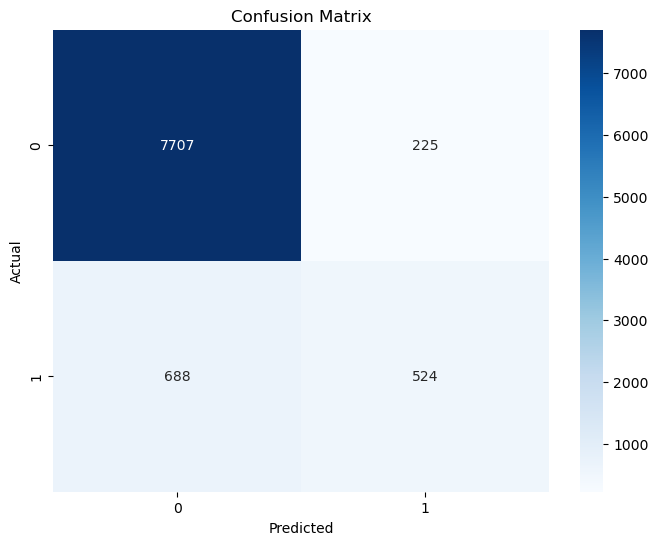

In [116]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()